Let us look at an example from Statistical Mechanics now. The goal of this notebook is to make the concepts of in-sample and out-of-sample errors, as well as $L^2$- and $L^1$-regularisation more intuitive from a physicists perspective. Below, we demonstrate that...

Consider the 1D Ising model with nearest-neighbour interactions 

$$H=-J\sum_{j=1}^L S_{j}S_{j+1}$$, $$H_\mathrm{model}[S^i] = - \sum_{j=1}^L \sum_{k=1}^L J_{j,k}S_{j}^iS_{k}^i =-\mathbf{X}^i \cdot \mathbf{J}$$

on a chain of length $L$ with $S_j=\pm 1$ the Ising spin variables. We use periodic boundary condtions. In one dimension, this paradigmatic model has no phase transition at finite temperature. Since the physics of the model is taught in every Statistical Mechanics textbook, we assume the reader is familiar with it, and focus here on the Machine Learning aspects instead. 

Suppose your boss set $J=1$, drew a large number of spin states, and computed their Ising energies. Then, without telling you about the above Hamiltonian, they just give you this data set. Your task is to learn the Hamiltonian using Linear regression techniques. 

In [10]:
import numpy as np
import scipy.sparse as sp
np.random.seed(12)

### define Ising model aprams
# system size
L=40

symmetric=False # interaction coupling symemtry
nn=False # nearest-neighbour only

if nn:
    n_feats=2*L
else:
    n_feats=L**2

n_samples=10000
noise_width=0.0

def unique_rows(a, **kwargs):
    """
    This function calculates the unique rows of an array and their indices.
    """
    rowtype = np.dtype((np.void, a.dtype.itemsize * a.shape[1]))
    b = np.ascontiguousarray(a).view(rowtype)
    return_index = kwargs.pop('return_index', False)
    out = np.unique(b, return_index=True, **kwargs)
    idx = out[1]
    uvals = a[idx]
    if (not return_index) and (len(out) == 2):
        return uvals
    elif return_index:
        return (uvals,) + out[1:]
    else:
        return (uvals,) + out[2:]

def ising_energies_1D(states,L,noise_width=0.0):
    """
    This function calculates the energies of the states in the nn Ising Hamiltonian
    """
    Jnn=np.zeros((L,L),)
    for i in range(L):
        Jnn[i,(i+1)%L]-=0.5
        Jnn[i,(i-1)%L]-=0.5
    # compute energies
    E = np.einsum('...i,ij,...j->...',states,Jnn,states)
    # extract indices of nn interactions for Jnn reshaped to 1D array (needed for linear regression)
    Jnn=Jnn.reshape(L*L,)
    J_sp = sp.csr_matrix(Jnn)
    inds_nn=J_sp.nonzero()[1]
    return E.reshape(-1,1), inds_nn

# create random Ising states
states=np.random.choice([-1, 1], size=(n_samples,L))
# calculate Ising energies
energies,inds_nn=ising_energies_1D(states,L,noise_width=noise_width)

# reshape states to fit the linear regression model: S_iS_j --> S_{ij}
states=np.einsum('...i,...j->...ij', states, states)
shape=states.shape
states=states.reshape((shape[0],shape[1]*shape[2]))

# take nearest neighbour elements only
if nn:
    states=states[:,inds_nn]

In [11]:
train_size=4000

# define train and test data
train_data_X=states[:train_size]
train_data_Y=energies[:train_size]

test_data_X=states[train_size:]
test_data_Y=energies[train_size:]

# define train data batch generator
def generate_batch(batch_size):
    """
    This function generates a train data batch of size batch_size
    """
    inds=np.arange(train_data_Y.shape[0])
    np.random.shuffle(inds)
    yield [train_data_X[inds[:batch_size]],train_data_Y[inds[:batch_size]]]

In [12]:
import sys, os
import tensorflow as tf
seed=12 #None
tf.set_random_seed(seed)

# create train data place holders
with tf.name_scope('data'):
    X=tf.placeholder(tf.float32, shape=(None,n_feats), name="X_data")
    Y=tf.placeholder(tf.float32, shape=(None,1), name="Y_data")

# create linear regression model
with tf.name_scope('model'):
    W=tf.Variable( tf.random_normal((n_feats,1), ),dtype=tf.float32, name="interaction")
    if symmetric:
        # get indices to do W.T on a flattened W
        inds_T=np.arange(L**2)
        inds_T=inds_T.reshape(L,L)
        inds_T=inds_T.T.reshape(L**2)
        if nn:
            inds_T=np.argsort(inds_T[inds_nn])
        # symmetrise J
        W=0.5*(W + tf.gather(W, inds_T))
    # compute model
    Y_predicted=tf.matmul(X,W)
    
# create loss function
with tf.name_scope('loss'):
    loss = tf.reduce_mean( tf.nn.l2_loss(Y - Y_predicted) )

# select optimiser

learning_rate=0.0001 
beta1=0.9 #0.94
beta2=0.99 #0.87
epsilon=1e-09
#opt_params=dict(learning_rate=learning_rate,beta1=beta1,beta2=beta2,epsilon=epsilon) # ADAM
opt_params=dict(learning_rate=learning_rate) # SGD

global_step=tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
with tf.name_scope('optimiser'):
    optimizer = tf.train.GradientDescentOptimizer(**opt_params).minimize(loss,global_step=global_step)
    #optimizer = tf.train.AdamOptimizer(**opt_params).minimize(loss,global_step=global_step)

('loss:', 0, 641.33154)
('Jmin,Jmax,Jmean:', 3.0493281, -2.9333389, -0.00023035645)
('loss:', 1, 436.52313)
('Jmin,Jmax,Jmean:', 2.9513638, -2.938633, 0.0001531756)
('loss:', 2, 465.43207)
('Jmin,Jmax,Jmean:', 2.9109149, -2.9213662, -0.0032249284)
('loss:', 3, 427.99716)
('Jmin,Jmax,Jmean:', 2.8703022, -2.9243522, -0.001380639)
('loss:', 4, 403.28601)
('Jmin,Jmax,Jmean:', 2.8639338, -2.8965185, -0.0022045302)
('loss:', 5, 424.97702)
('Jmin,Jmax,Jmean:', 2.9039886, -2.8673825, 0.00053801778)
('loss:', 6, 459.33398)
('Jmin,Jmax,Jmean:', 2.8264985, -2.8679252, -0.0025058126)
('loss:', 7, 456.04922)
('Jmin,Jmax,Jmean:', 2.7927816, -2.886034, -0.0041099428)
('loss:', 8, 473.52618)
('Jmin,Jmax,Jmean:', 2.727392, -2.8770628, -0.0048955502)
('loss:', 9, 289.52917)
('Jmin,Jmax,Jmean:', 2.7206044, -2.8240662, -0.0061757006)
('loss:', 10, 378.3732)
('Jmin,Jmax,Jmean:', 2.7224989, -2.8115323, -0.0065257777)
('loss:', 11, 338.57593)
('Jmin,Jmax,Jmean:', 2.7888582, -2.7772291, -0.0078919716)
('loss:

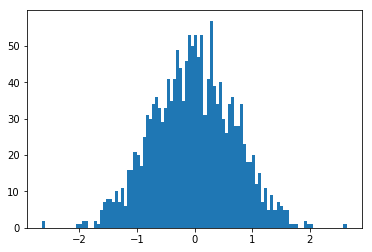

('\\sum_j J_{jj}=', 5.9604645e-08)


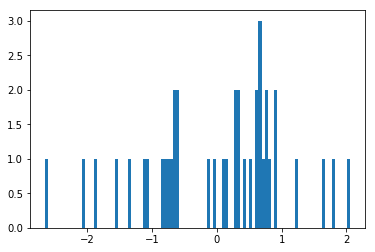

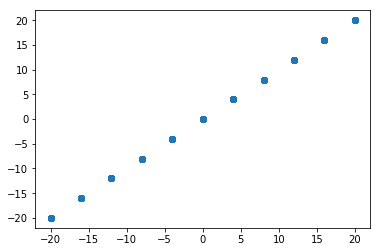

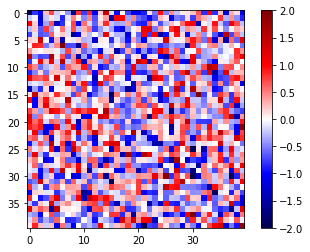

In [13]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

training_epochs=2000 # number of training epochs
batch_size=100 # batch size

# train and test model
with tf.Session() as sess:
    # initialize the necessary variables
    sess.run(tf.global_variables_initializer())
    
    # train model
    for index in range(training_epochs): 
        
        batch_X, batch_Y = generate_batch(batch_size).next()
        #print(batch_X.shape,batch_Y.shape)

        loss_batch, _, = sess.run([loss, optimizer], feed_dict={X: batch_X, Y: batch_Y} )
        
        # count training step
        step = sess.run(global_step)
        
        print("loss:", index, sess.run( loss/batch_size, feed_dict={X: batch_X, Y: batch_Y}) )
        
        J=sess.run(W)
        print("Jmin,Jmax,Jmean:", np.max(J), np.min(J), np.mean(J) )
        
    # test model
    print(sess.run( loss/(n_samples-train_size), feed_dict={X: test_data_X, Y: test_data_Y}) )
    
    if nn:
        plt.hist(J,bins=100)
        plt.show()
        
        Y,Y_predicted=sess.run([Y,Y_predicted], feed_dict={X: test_data_X, Y: test_data_Y})

        plt.scatter(Y,Y_predicted)
        plt.show()
        
    else:
        J = sess.run(W)
        print("J:", np.max(J), np.min(J), np.mean(J) )


        plt.hist(J,bins=100)
        plt.show()

        print("\sum_j J_{jj}=", np.sum(J[[i*(L+1) for i in range(L)]]) )

        plt.hist(J[[i*(L+1) for i in range(L)]],bins=100)
        plt.show()

        Y,Y_predicted=sess.run([Y,Y_predicted], feed_dict={X: test_data_X, Y: test_data_Y})

        plt.scatter(Y,Y_predicted)
        plt.show()

        Jij=J.reshape((L,L))

        cmap_args=dict(vmin=-2., vmax=2., cmap='seismic')

        plt.imshow(Jij.reshape(L,L),**cmap_args)
        plt.colorbar()
        plt.show()